**<font size="5">VIDEO COLORIZATION PROJECT</font>**

**<font size="4">(I) Training Model</font>**

**<font size="3">Step-1: Import Necessary Libraries</font>**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
from torchvision import datasets, transforms

import os, shutil, time

import cv2
from glob import glob

from imageai.Detection import ObjectDetection
import tensorflow as tf

import pandas as pd
import time

**<font size="3">Step-2: Separate Images into training and validation set</font>**

In [2]:
os.makedirs('images/train/class/', exist_ok=True)
os.makedirs('images/val/class/', exist_ok=True)
for i, file in enumerate(os.listdir('testSet_resize')): ## 41000 images => 40,000 + 1,000
  if i < 1000:
    os.rename('testSet_resize/' + file, 'images/val/class/' + file)
  else: # others will be val
    os.rename('testSet_resize/' + file, 'images/train/class/' + file)

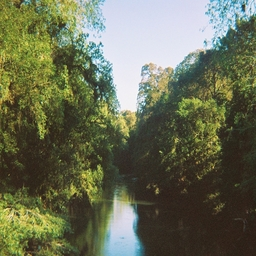

In [2]:
from IPython.display import Image, display
display(Image(filename='images/val/class/000b5757932a8050337257fdae2c9942.jpg'))

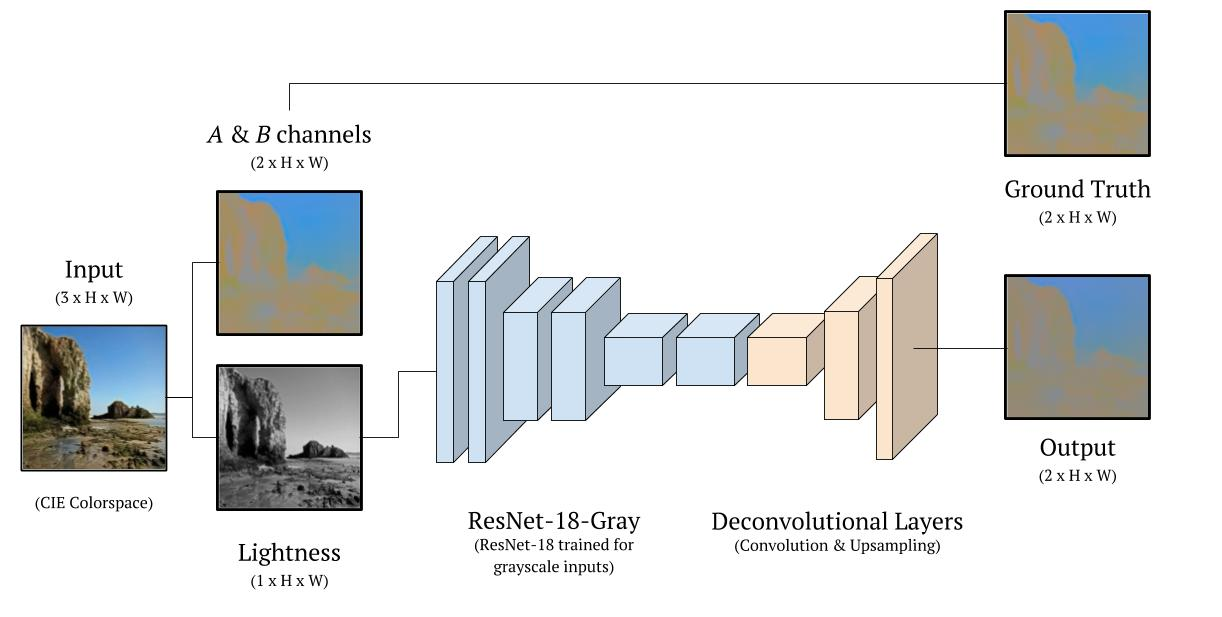

In [3]:
display(Image(filename='CNN_for_proj.jpg'))

**<font size="3">Step3: Colorizing Network (CNN)</font>**

<font size="3">Convolutional Neural Networks (CNN or ConvNet) are complex feed forward neural networks. CNNs are used for image classification and recognition because of its high accuracy. The CNN follows a hierarchical model which works on building a network, like a funnel, and finally gives out a fully-connected layer where all the neurons are connected to each other and the output is processed.</font>

In [4]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128
# residual network
    resnet = models.resnet18(num_classes=365)
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 

    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):


    midlevel_features = self.midlevel_resnet(input)


    output = self.upsample(midlevel_features)
    return output

In [5]:
model = ColorizationNet()

In [6]:
criterion = nn.MSELoss() # Mean Squared Error

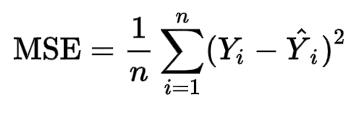

In [7]:
display(Image(filename='mse.jpg'))

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)

<font size="3">Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data.<br>
Adam learns the learning rates itself, on a per-parameter basis.This is in huge contrast with stock vanilla Stochastic Gradient Descent, where:
learning rates are not per-parameter, but there is a single, global learning rate, that is applied bluntly, across all parameters</font>

**<font size="3">Step4: Creating grayscale and corresponding cie images from rgb images</font>**

In [9]:
class GrayscaleImageFolder(datasets.ImageFolder):
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_original = rgb2gray(img_original)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original, img_ab, target #img_original=>Grayscale; img_ab=>CIELAB a&b comp; target=>RGB image

In [10]:
# Training
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('images/train', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)

# Validation 
val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
val_imagefolder = GrayscaleImageFolder('images/val' , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)

In [11]:
class AverageMeter(object):
 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  # Combine CIE LAB and GREYSCALE images into RGB
  # save_path is in the form {'grayscale': '/path/', 'colorized': '/path/'}
  plt.clf()
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combines the two
  color_image = color_image.transpose((1, 2, 0))
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    if 'grayscale' in save_path.keys():
        plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    if 'colorized' in save_path.keys():
        plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

**<font size="3">Step5: Validate and train functions</font>**

In [12]:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  # Create value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()
  shutil.rmtree('outputs/color')
  shutil.rmtree('outputs/gray')
  os.makedirs('outputs/color', exist_ok=True)
  os.makedirs('outputs/gray', exist_ok=True)
  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Run model and record loss
    output_ab = model(input_gray)
    loss = criterion(output_ab, input_ab) # MSE
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Finished validation.')
  return losses.avg

In [13]:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray) 
    loss = criterion(output_ab, input_ab) 
    losses.update(loss.item(), input_gray.size(0))

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 

  print('Finished training epoch {}'.format(epoch))

**<font size="3">Step6: Training</font>**

In [15]:
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 2

In [65]:
# Train model
for epoch in range(epochs):
  # Train for one epoch, then validate
  train(train_loader, model, criterion, optimizer, epoch)
  with torch.no_grad():
    losses = validate(val_loader, model, criterion, save_images, epoch)
  # Save checkpoint and replace old best model if current model is better
  if losses < best_losses:
    best_losses = losses
    torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses))


Starting training epoch 0
Epoch: [0][0/625]	Time 19.725 (19.725)	Data 6.309 (6.309)	Loss 2.0718 (2.0718)	
Epoch: [0][25/625]	Time 17.215 (17.322)	Data 4.858 (4.886)	Loss 0.0106 (0.1950)	
Epoch: [0][50/625]	Time 16.060 (17.730)	Data 4.784 (4.858)	Loss 0.0076 (0.1040)	
Epoch: [0][75/625]	Time 16.567 (17.550)	Data 4.792 (4.802)	Loss 0.0053 (0.0721)	
Epoch: [0][100/625]	Time 22.589 (18.493)	Data 5.184 (4.900)	Loss 0.0067 (0.0556)	
Epoch: [0][125/625]	Time 14.417 (18.214)	Data 3.622 (4.774)	Loss 0.0043 (0.0454)	
Epoch: [0][150/625]	Time 14.564 (17.740)	Data 3.937 (4.651)	Loss 0.0027 (0.0385)	
Epoch: [0][175/625]	Time 14.371 (17.326)	Data 3.793 (4.537)	Loss 0.0042 (0.0337)	
Epoch: [0][200/625]	Time 15.587 (17.114)	Data 4.292 (4.543)	Loss 0.0050 (0.0300)	
Epoch: [0][225/625]	Time 15.365 (16.908)	Data 3.772 (4.490)	Loss 0.0045 (0.0271)	
Epoch: [0][250/625]	Time 15.138 (16.733)	Data 4.100 (4.472)	Loss 0.0029 (0.0248)	
Epoch: [0][275/625]	Time 15.224 (16.565)	Data 4.004 (4.419)	Loss 0.0035 (0.02

In [66]:
torch.save(model.state_dict(),'model-epoch.pth')

**<font size="3">Step7: Testing (Image Colorizing)</font>**

In [14]:
model2 = ColorizationNet()
pretrained = torch.load('model-epoch.pth', map_location=lambda storage, loc: storage)
model2.load_state_dict(pretrained)

<All keys matched successfully>

In [15]:
save_images = True
with torch.no_grad():
  validate(val_loader, model2, criterion, save_images, 0)

Validate: [0/16]	Time 7.108 (7.108)	Loss 0.0031 (0.0031)	
Finished validation.


<Figure size 432x288 with 0 Axes>

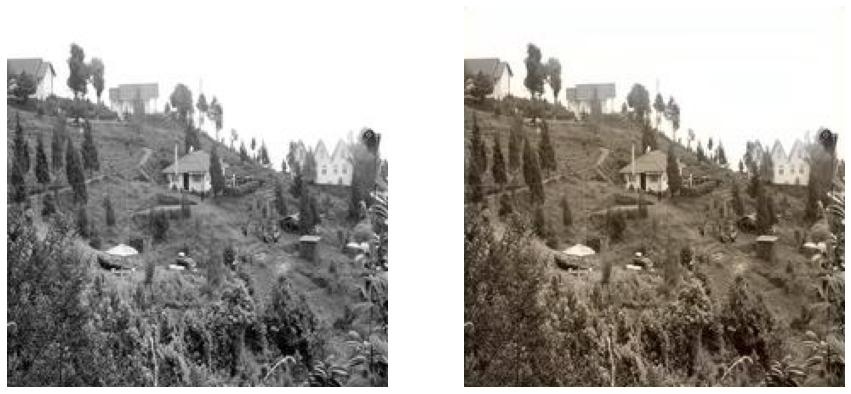

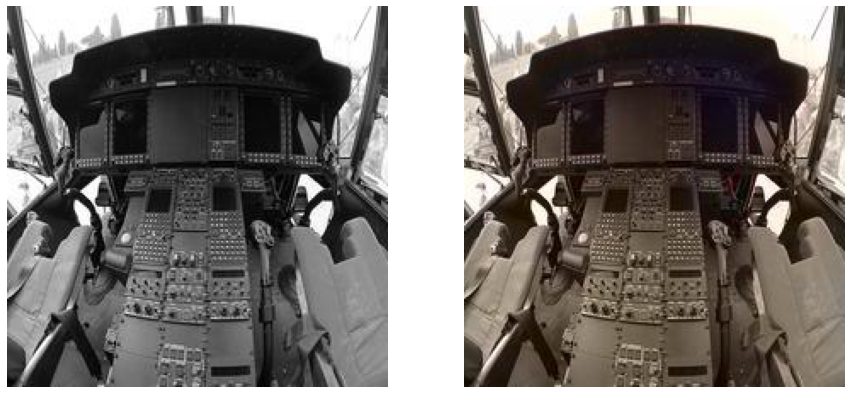

In [16]:
import matplotlib.image as mpimg
image_pairs = [('outputs/color/img-4-epoch-0.jpg', 'outputs/gray/img-4-epoch-0.jpg'),
               ('outputs/color/img-2-epoch-0.jpg', 'outputs/gray/img-2-epoch-0.jpg')]
for c, g in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  f, axarr = plt.subplots(1, 2)
  f.set_size_inches(15, 15)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[0].axis('off'), axarr[1].axis('off')
  plt.show()

**<font size="3">Step7: Execution (Demo)(Video Colorizing)</font>**

**<font size="3">(i) MODULE 1: INPUT VIDEO PREPROCESSING (Splitting) (Input Gray scale Video -> List of Frames)</font>**

In [14]:
def create_dir(path):
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print(f"ERROR: creating directory with name {path}")

In [29]:
def save_frame(video_path,save_dir):
    create_dir(save_dir)
    cap=cv2.VideoCapture(video_path)
    idx=0
    print('Frame :',end=' ')
    while True:
        print(idx,end=',')
        ret,frame=cap.read()
        if ret==False:
            cap.release()
            break

        temp_dir = os.path.join(save_dir, str(idx))
        save_path = os.path.join(temp_dir, 'class')
        create_dir(save_path)
        cv2.imwrite(f"{save_path}/{idx}.png",frame)
        
        idx+=1
    print('')
    return idx-1

**<font size="3">(ii) MODULE 2: CNN MODEL PREDICTION (Colorizing) (List of gray scale frames -> List of rgb colored frames)</font>**

In [16]:
class InputGrayFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img_original = self.transform(img)
            img_original = np.asarray(img_original)
            img_original = rgb2gray(img_original)
            img_original = torch.from_numpy(img_original).unsqueeze(0).float()
            return img_original

In [43]:
def predict(test_loader, model, save_images, save_name):
  model.eval()    
  count = 0
  for i, input_gray in enumerate(test_loader):
      output_ab = model(input_gray)
      save_path = {'colorized': save_images}
      to_rgb(input_gray[0].cpu(), ab_input=output_ab[0].detach().cpu(), save_path=save_path, save_name=save_name)

**<font size="3">(iii) MODULE 3: OUTPUT VIDEO PROCESSING (Merging) (list of frames -> Color Video)</font>**

In [44]:
def merger(number_of_files, save_dir_for_color):
    print('Frame :',end=' ')
    for x in range (number_of_files):
        print(x,end=',')
        global size
        img = cv2.imread('{0}/{1}.png'.format(save_dir_for_color,x))
        height, width, layers = img.shape
        size = (width, height)
        img_array.append (img)
    print('')
    print('Merging Completed.')
    out = cv2.VideoWriter('project.avi', cv2.VideoWriter_fourcc (*'DIVX'), 15, size)

    for i in range (len (img_array)):
        out.write (img_array[i])
    out.release ()
    print('Final video PROJECT.AVI released.')
    return os.getcwd()+'\\'+'project.avi'

**<font size="3">(iv) Execution </font>**

In [51]:
## EXECUTING MODULE 1 ---------

test_path = input('Enter the video path')
print('---- Splitting Video Frames ----')
print('')
print('Video File path is :',test_path)
print('Splitting the video frames ....')
video_name = list(list(test_path.split('\\'))[-1].split('.'))[0].strip()
video_paths=glob(test_path)
save_dir_for_gray = video_name + "/gray_scale_frames"

number_of_files = 0
for path in video_paths:
    number_of_files += save_frame(path,save_dir_for_gray)

print('Split completed.')
print('Number of frames extracted from video :',number_of_files)
print('Frames saved in location :',save_dir_for_gray)
print('')

## -------- END OF MODULE 1 EXECUTION

## EXECUTING MODULE 2 ----------

print('---- Colorizing Video Frames ----')
print('')
print('Loading CNN Trained Model ...',end=' ')
model_for_testing = ColorizationNet()
pretrained = torch.load('model-epoch.pth', map_location=lambda storage, loc: storage)
model_for_testing.load_state_dict(pretrained)
print('Model Loaded.')

test_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])

print('Colorizing the Frames')
print('Frame:',end=' ')
for i in range(number_of_files):
    print(i,end=',')
    test_imagefolder = InputGrayFolder('{0}/{1}'.format(save_dir_for_gray, i) , test_transforms)
    test_loader = torch.utils.data.DataLoader(test_imagefolder,batch_size=1, shuffle=False)

    save_dir_for_color = video_name + '/color_frames/'
    create_dir(save_dir_for_color)
    predict(test_loader, model_for_testing, save_dir_for_color, str(i)+'.png')
print('')
print('Colorization completed')
print('Total Number of colored Frames',number_of_files)
print('Colored Frames stored in location :',save_dir_for_color)
print('')

## --------- END OF MODULE 2 EXECUTION

## EXECUTING MODULE 3 -----------

print('---- Merging Colored Frames ----')
print('')
img_array = []
number_of_files = len([name for name in os.listdir(save_dir_for_color)])

print('Starting to Merge Frames ... ')
video_loc = merger(number_of_files, save_dir_for_color)
print('Video file stored in location :',video_loc)
print('')
## ---------- END OF MODULE 3 EXECUTION

print('Execution Completed.')


Enter the video pathC:\Users\Guru Prasad\Documents\mlproject\videos\test4.mp4
---- Splitting Video Frames ----

Video File path is : C:\Users\Guru Prasad\Documents\mlproject\videos\test4.mp4
Splitting the video frames ....
Frame : 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219

<Figure size 432x288 with 0 Axes>

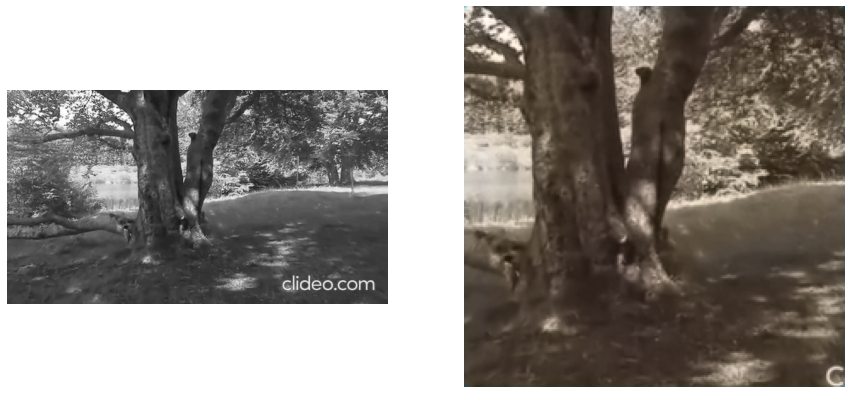

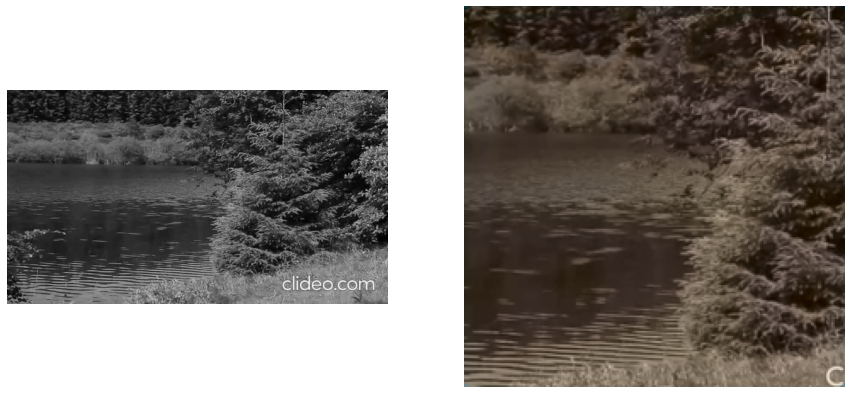

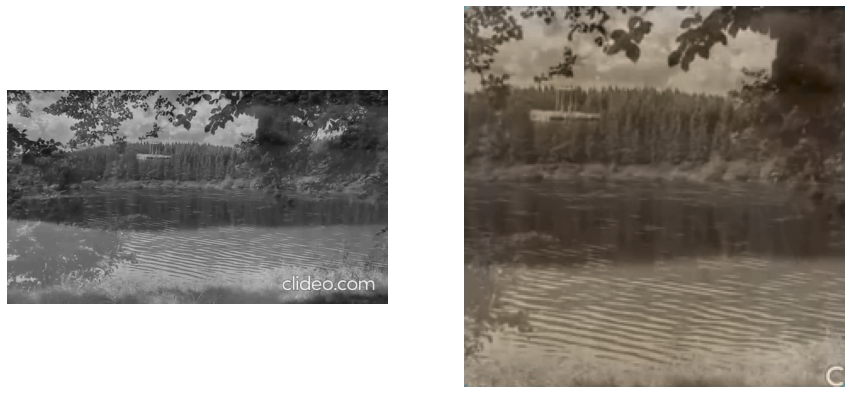

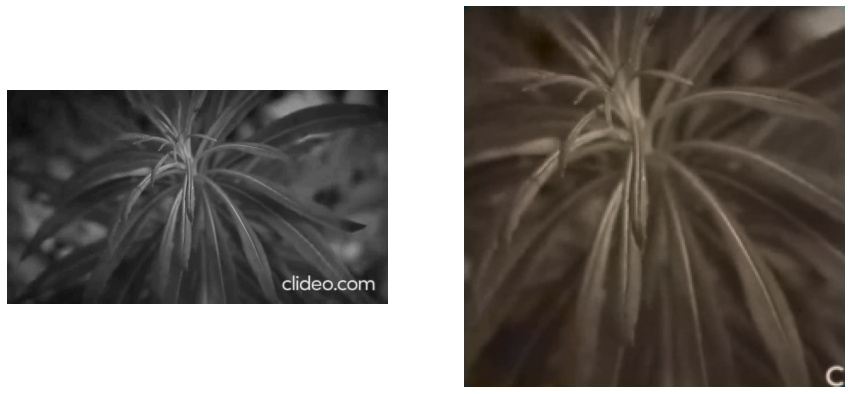

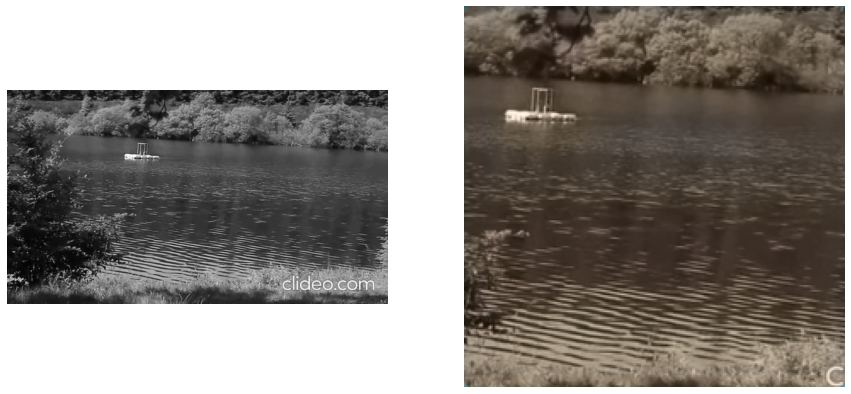

In [52]:
## Sample Frames

import matplotlib.image as mpimg
image_pairs = [(save_dir_for_color+'100.png', save_dir_for_gray+'/100/class/100.png'),
               (save_dir_for_color+'500.png', save_dir_for_gray+'/500/class/500.png'),
               (save_dir_for_color+'300.png', save_dir_for_gray+'/300/class/300.png'),
               (save_dir_for_color+'400.png', save_dir_for_gray+'/400/class/400.png'),
               (save_dir_for_color+'350.png', save_dir_for_gray+'/350/class/350.png')]
for c, g in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  f, axarr = plt.subplots(1, 2)
  f.set_size_inches(15, 15)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[0].axis('off'), axarr[1].axis('off')
  plt.show()

In [ ]:
C:\Users\Guru Prasad\Documents\mlproject\videos\pexels-jill-burrow-6402550.mp4
C:\Users\Guru Prasad\Documents\mlproject\videos\Pexels Videos 1879456.mp4
C:\Users\Guru Prasad\Documents\mlproject\videos\test1.mp4
C:\Users\Guru Prasad\Documents\mlproject\videos\test2.mp4
C:\Users\Guru Prasad\Documents\mlproject\videos\test3.mp4
C:\Users\Guru Prasad\Documents\mlproject\videos\test4.mp4
C:\Users\Guru Prasad\Documents\mlproject\videos\test5.mp4

**<font size="3">Step8: Calculating Accuracy Metrics</font>**

**<font size="3">(i) Speed of Colorization</font>**

In [38]:
## EXECUTING MODULE 1 ---------

test_path = input('Enter the video path')
video_name = list(list(test_path.split('\\'))[-1].split('.'))[0].strip()
video_paths=glob(test_path)
save_dir_for_gray = video_name + "/gray_scale_frames"

number_of_files = 0
for path in video_paths:
    number_of_files += save_frame(path,save_dir_for_gray)

print('Total Frames :',number_of_files)

## -------- END OF MODULE 1 EXECUTION

## EXECUTING MODULE 2 ----------

model_for_testing = ColorizationNet()
pretrained = torch.load('model-epoch.pth', map_location=lambda storage, loc: storage)
model_for_testing.load_state_dict(pretrained)

test_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])

total_time = 0

for i in range(number_of_files):
    test_imagefolder = InputGrayFolder('{0}/{1}'.format(save_dir_for_gray, i) , test_transforms)
    test_loader = torch.utils.data.DataLoader(test_imagefolder,batch_size=1, shuffle=False)

    save_dir_for_color = video_name + '/color_frames/'
    create_dir(save_dir_for_color)
    start = time.time()
    predict(test_loader, model_for_testing, save_dir_for_color, str(i)+'.png')
    end = time.time()
    total_time += (end - start)

avg_time = total_time / number_of_files
print('Total Time required to colorize all the images in the video:',total_time,'s')
print('Average Time required to colorize a frame:', avg_time,'s')

Enter the video pathC:\Users\Guru Prasad\Documents\mlproject\videos\Pexels Videos 1879456.mp4
Total Frames : 786
Total Time required to colorize all the images in the video: 123.30691480636597 s
Average Time required to colorize a frame: 0.15687902647120353 s


<Figure size 432x288 with 0 Axes>

**<font size="3">(ii) Measuring Clarity of colorized images</font>**

In [21]:
model_for_testing = ColorizationNet()
pretrained = torch.load('model-epoch.pth', map_location=lambda storage, loc: storage)
model_for_testing.load_state_dict(pretrained)

accuracy_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
print('Colorizing 20 images stored at location accuracy/')
print('Image :',end="")
for i in range(20):
    print(i,end=',')
    accuracy_imagefolder = InputGrayFolder('accuracy/{0}'.format(i), accuracy_transforms)
    accuracy_loader = torch.utils.data.DataLoader(accuracy_imagefolder,num_workers = 0,batch_size=1, shuffle=False)

    save_dir_for_color = 'accuracy_colored/'
    predict(accuracy_loader, model_for_testing, save_dir_for_color, str(i)+'.png')
print('')
print('Finished Colorizing')
print('Colored Images stored at location accuracy_colored/')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
execution_path = os.getcwd()
print('Loading Detection Model ...',end=' ')
detector = ObjectDetection()
detector.setModelTypeAsRetinaNet()
detector.setModelPath( os.path.join(execution_path , "resnet50_coco_best_v2.1.0.h5"))
detector.loadModel()
print('Finished Loading')

Colorizing 20 images stored at location accuracy/
Image :0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
Finished Colorizing
Colored Images stored at location accuracy_colored/
Loading Detection Model ... Finished Loading


<Figure size 432x288 with 0 Axes>

In [22]:
df = pd.read_csv('test.csv')
df.head(20)

,image,objects
0,0,zebra
1,1,horse
2,2,cup;bowl;dining table
3,3,person
4,4,person
5,5,person
6,6,clock
7,7,dog
8,8,chair;dining table
9,9,chair


In [42]:
correct_count = 0
total_count = 0

for i in range(20):
    print('Image',i)
    objects = df.loc[i,'objects']
    objects = list(objects.split(';'))

    detections = detector.detectObjectsFromImage(input_image=os.path.join(execution_path , "accuracy_colored/{0}.png".format(i)), output_image_path=os.path.join(execution_path , "accuracy_result/{0}.png".format(i)))
    detections = [i['name'] for i in detections]
    print('Prediction:',detections)
    total_count += len(objects)
    temp = 0
    for each_object in objects:
        if each_object in detections:
            temp+=1
    correct_count += temp
    print(temp,'/',len(objects),'objects have been identified')
            
print('Out of',total_count,'objects in 20 images,',correct_count,'objects where identified')
print('Accuracy:',correct_count/total_count*100)

Image 0
Prediction: ['zebra']
1 / 1 objects have been identified
Image 1
Prediction: ['horse']
1 / 1 objects have been identified
Image 2
Prediction: ['bowl', 'dining table']
2 / 3 objects have been identified
Image 3
Prediction: ['person', 'bottle', 'clock', 'bottle', 'person']
1 / 1 objects have been identified
Image 4
Prediction: ['person']
1 / 1 objects have been identified
Image 5
Prediction: ['person']
1 / 1 objects have been identified
Image 6
Prediction: ['clock', 'clock', 'clock', 'clock']
1 / 1 objects have been identified
Image 7
Prediction: ['dog']
1 / 1 objects have been identified
Image 8
Prediction: ['chair', 'chair', 'chair', 'chair', 'dining table', 'chair', 'dining table', 'chair']
2 / 2 objects have been identified
Image 9
Prediction: ['chair']
1 / 1 objects have been identified
Image 10
Prediction: ['bed']
1 / 1 objects have been identified
Image 11
Prediction: ['laptop']
1 / 1 objects have been identified
Image 12
Prediction: ['person', 'boat']
2 / 2 objects have b

**<font size="3">(iii) Measuring Correctness (Closeness of the predicted image to the actual image)</font>**

In [43]:
def accuracy_predict(input_gray, input_ab, model):
  model.eval()    
  count = 0
  output_ab = model(input_gray)
  return (input_ab.detach().numpy(), output_ab.detach().numpy())

In [44]:
accuracy2_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
accuracy2_imagefolder = GrayscaleImageFolder('accuracy2/' , accuracy2_transforms)
accuracy2_loader = torch.utils.data.DataLoader(accuracy2_imagefolder, batch_size=1, shuffle=False)

In [46]:
model_for_testing = ColorizationNet()
pretrained = torch.load('model-epoch.pth', map_location=lambda storage, loc: storage)
model_for_testing.load_state_dict(pretrained)

total_sum = 0
number_of_images = 0
for i, (input_gray,input_ab,target) in enumerate(accuracy2_loader):
    number_of_images += 1
    actual_ab, predicted_ab = accuracy_predict(input_gray,input_ab, model_for_testing)
    actual_u = actual_ab[:,0,:,:]
    actual_v = actual_ab[:,1,:,:]
    predicted_u = predicted_ab[:,0,:,:]
    predicted_v = predicted_ab[:,1,:,:]
    temp = (np.linalg.norm(actual_u-predicted_u) + np.linalg.norm(actual_v - predicted_v))
    print('Closeness of Image',i,':',temp)
    total_sum += temp
avg_closeness = total_sum / number_of_images
print('')
print('Average Closeness',avg_closeness)

Closeness of Image 0 : 14.592848
Closeness of Image 1 : 28.269836
Closeness of Image 2 : 13.674025
Closeness of Image 3 : 34.178337
Closeness of Image 4 : 21.08085
Closeness of Image 5 : 27.015827
Closeness of Image 6 : 32.195503
Closeness of Image 7 : 41.561493
Closeness of Image 8 : 14.019655
Closeness of Image 9 : 25.616985
Closeness of Image 10 : 13.54761
Closeness of Image 11 : 8.31824
Closeness of Image 12 : 38.395844
Closeness of Image 13 : 13.564478
Closeness of Image 14 : 31.789658
Closeness of Image 15 : 39.290203
Closeness of Image 16 : 30.270748
Closeness of Image 17 : 35.008446
Closeness of Image 18 : 12.017047
Closeness of Image 19 : 11.798961

Average Closeness 24.310329723358155
